# Web Scraping PokeAPI Data

In [5]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import io
import json

In [ ]:
# base url for the PokeAPI website
poke_url = 'https://pokeapi.co/api/v2/pokemon/'

In [ ]:
# retrieves Pokemon names
pokemon_name_list = [requests.get(poke_url + str(i+1) + '/').json()['name'] for i in range(0, 1010)]

In [ ]:
# retrieves base stats for all Pokemon
base_stats_list = [j['base_stat'] for i in range(0, 1010) for j in requests.get(poke_url + str(i+1)).json()['stats']]

In [ ]:
# create empty lists for each base stat
hp_stat = []
attack_stat = []
defense_stat = []
special_attack_stat = []
special_defense_stat = []
speed_stat = []

# put base stat value in appropriate list
for i in range(len(base_stats_list)):
    if i % 6 == 0:
        hp_stat.append(base_stats_list[i])
    elif i % 6 == 1:
        attack_stat.append(base_stats_list[i])
    elif i % 6 == 2:
        defense_stat.append(base_stats_list[i])
    elif i % 6 == 3:
        special_attack_stat.append(base_stats_list[i])
    elif i % 6 == 4:
        special_defense_stat.append(base_stats_list[i])
    else:
        speed_stat.append(base_stats_list[i])

In [59]:
# some Pokemon have one type while others, like Charizard, have two
len(requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'])

2

In [62]:
# see what the types are
requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types']

[{'slot': 1,
  'type': {'name': 'fire', 'url': 'https://pokeapi.co/api/v2/type/10/'}},
 {'slot': 2,
  'type': {'name': 'flying', 'url': 'https://pokeapi.co/api/v2/type/3/'}}]

In [60]:
# pull the specific type
requests.get('https://pokeapi.co/api/v2/pokemon/charizard').json()['types'][0]['type']['name']

'fire'

In [ ]:
# create lists for type 1 and type 2
type1 = []
type2 = []

# append the type to the appropriate list
for t in range(1010):
    if len(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types']) == 1:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append('')
    else:
        type1.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][0]['type']['name'])
        type2.append(requests.get('https://pokeapi.co/api/v2/pokemon/' + str(t+1) + '/').json()['types'][1]['type']['name'])

In [ ]:
# create pandas data frame
dictionary = {"Pokemon Name" : pokemon_name_list, "Type 1" : type1, "Type 2" : type2, "hp" : hp_stat, "attack" : attack_stat, "defense" : defense_stat,
             "special attack" : special_attack_stat, "special defense" : special_defense_stat, "speed" : speed_stat}
pokemon_df = pd.DataFrame(dictionary)

In [3]:
# create CSV of pandas data frame
pokemon_df.to_csv('pokemon_type_and_base_stats.csv', index=False)

NameError: name 'pokemon_df' is not defined

# Feature Engineering PokeAPI Data

In [33]:
# create combinations of the sums of different base stats
pokemon_df_stat_combos = pokemon_df.copy()
pokemon_df_stat_combos['attack and special attack'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['special attack']
pokemon_df_stat_combos['defense and special defense'] = pokemon_df_stat_combos['defense'] + pokemon_df_stat_combos['special defense']
pokemon_df_stat_combos['attack and speed'] = pokemon_df_stat_combos['attack'] + pokemon_df_stat_combos['speed']
pokemon_df_stat_combos['special attack and speed'] = pokemon_df_stat_combos['special attack'] + pokemon_df_stat_combos['speed']
pokemon_df_stat_combos.drop(['attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [34]:
# create CSV
pokemon_df_stat_combos.to_csv('pokemon_type_and_base_stats_combos.csv', index=False)

In [35]:
# create ratios of the different base stats by dividing by "speed"
pokemon_df_stat_ratios = pokemon_df.copy()
pokemon_df_stat_ratios['hp / speed'] = pokemon_df_stat_ratios['hp'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['attack / speed'] = pokemon_df_stat_ratios['attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['defense / speed'] = pokemon_df_stat_ratios['defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special attack / speed'] = pokemon_df_stat_ratios['special attack'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios['special defense / speed'] = pokemon_df_stat_ratios['special defense'] / pokemon_df_stat_ratios['speed']
pokemon_df_stat_ratios.drop(['hp', 'attack', 'defense', 'special attack', 'special defense', 'speed'], axis=1, inplace=True)

In [37]:
# create CSV
pokemon_df_stat_ratios.to_csv('pokemon_type_and_base_stats_ratios.csv', index=False)

In [90]:
# read in the CSV files
pokemon_df = pd.read_csv('pokemon_type_and_base_stats.csv')
pokemon_df_combos = pd.read_csv('pokemon_type_and_base_stats_combos.csv')
pokemon_df_ratios = pd.read_csv('pokemon_type_and_base_stats_ratios.csv')

# EDA, Preprocessing, and Feature Engineering Kaggle Dataset

https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080 has some good EDA, some of which I have used as well.

In [98]:
from pathlib import Path
import os

# create path object to get into the images directory
path1 = Path('images/images')

# create a list of the file paths that end in .png
files_paths = list(path1.glob('*.png'))

# list comprehension that gets the second element of each tuple of the split path ([pokemon_name].png)
names = [os.path.split(x)[1] for x in files_paths]

# concatenate names list and files_paths list
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files_paths, name='Filepath').astype(str)], axis=1)

# regex matches the file extension
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x))
image_df.head()

,Name,Filepath
0,abomasnow,images\images\abomasnow.png
1,abra,images\images\abra.png
2,absol,images\images\absol.png
3,accelgor,images\images\accelgor.png
4,aegislash-blade,images\images\aegislash-blade.png


In [108]:
# read in pokemon.csv
pokemon = pd.read_csv('pokemon.csv')

# merge image_df and pokemon data frames on the "Name" column
df = image_df.merge(pokemon, on='Name')

# drop the Name and Type2 columns
df = df.drop(['Name', 'Type2'], axis=1) 
df.head()

,Filepath,Type1
0,images\images\abomasnow.png,Grass
1,images\images\abra.png,Psychic
2,images\images\absol.png,Dark
3,images\images\accelgor.png,Bug
4,images\images\aegislash-blade.png,Steel


In [109]:
import seaborn as sns

# assigns colors to the different types for visualizations
custom_colors = {
    'Normal': 'gray',
    'Fire': 'orange',
    'Water': 'blue',
    'Grass': 'green',
    'Fairy': 'pink',
    'Fighting': 'red',
    'Dark': 'black',
    'Flying': 'turquoise', 
    'Ghost': 'purple',
    'Electric': 'yellow',
    'Ground': 'brown',
    'Ice': 'white',
    'Bug': '#003008',
    'Poison': 'magenta',
    'Psychic': 'lavender',
    'Rock': 'burlywood',
    'Steel': 'silver',
    'Dragon': 'indigo'
}

In [110]:
# make a list of the types
types = list(custom_colors.keys())

# loop through the types and count the number of values that match the type name
type_nums = []
for type_ in types:
    type_nums.append(sum(df['Type1']==type_))

# create data frame and sort in descending order by Count
data = {'Count': type_nums}
data_df = pd.DataFrame(data, index=types).sort_values(by='Count', ascending=False)

# get the types
types = data_df.index.to_list()

# rearrange the colors to match key order with "types" order
rearranged_colors = {key: custom_colors[key] for key in types}

# get color palette
sns.set_palette(sns.color_palette(rearranged_colors.values()))

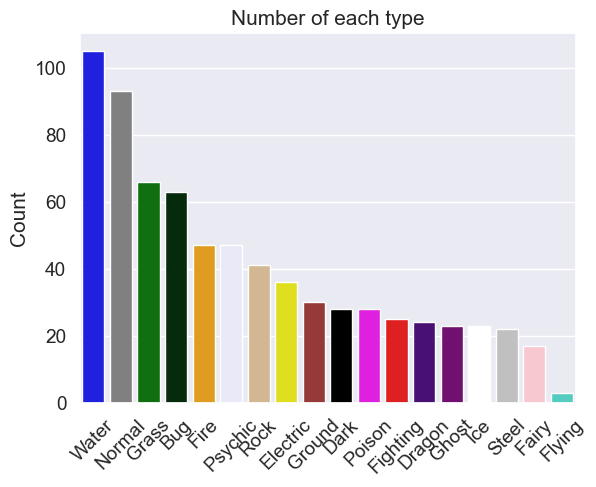

In [111]:
# create barplot of the count of each type in descending order
plt.title('Number of each type')
ax = sns.barplot(x=data_df.index, y='Count', data=data_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

# CNN with Kaggle Dataset

In [112]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [126]:
X_train, X_test = train_test_split(df, test_size=.2, random_state=42)

In [131]:
# create image generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# create training set
train_data = datagen.flow_from_dataframe(
    X_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

# create validation set
val_data = datagen.flow_from_dataframe(
    X_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

# create test set
test_data = datagen.flow_from_dataframe(
    X_test,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
)

Found 461 validated image filenames belonging to 18 classes.
Found 115 validated image filenames belonging to 18 classes.
Found 145 validated image filenames belonging to 18 classes.


In [132]:
# create the CNN model
# pretty bad when trying to do all 18 types
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(18, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
15/15 [==============================] - 12s 680ms/step - loss: 3.0023 - accuracy: 0.0738 - val_loss: 2.7912 - val_accuracy: 0.0870
Epoch 2/10
15/15 [==============================] - 9s 582ms/step - loss: 2.6065 - accuracy: 0.1714 - val_loss: 2.7920 - val_accuracy: 0.1217
Epoch 3/10
15/15 [==============================] - 8s 562ms/step - loss: 2.2032 - accuracy: 0.3145 - val_loss: 2.8575 - val_accuracy: 0.1043
Epoch 4/10
15/15 [==============================] - 9s 589ms/step - loss: 1.3964 - accuracy: 0.5553 - val_loss: 3.7285 - val_accuracy: 0.0696
Epoch 5/10
15/15 [==============================] - 9s 596ms/step - loss: 0.7343 - accuracy: 0.7701 - val_loss: 4.4623 - val_accuracy: 0.0696
Epoch 6/10
15/15 [==============================] - 9s 590ms/step - loss: 0.3279 - accuracy: 0.9111 - val_loss: 6.1751 - val_accuracy: 0.0522
Epoch 7/10
15/15 [==============================] - 9s 605ms/step - loss: 0.1640 - accuracy: 0.9501 - val_loss: 6.9436 - val_accuracy: 0.0870
Epoch

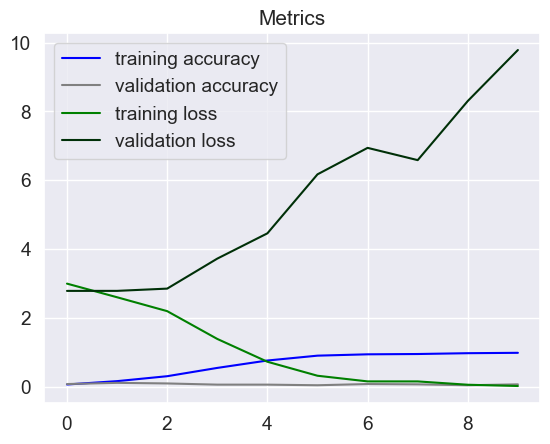

In [137]:
# plot the training and validation accuracies and the training and validation losses
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

plt.plot(epochs, accuracy, label='training accuracy')
plt.plot(epochs, val_accuracy, label='validation accuracy')
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [135]:
test_loss, test_accuracy = cnn_model.evaluate(test_data)
print('Testing accuracy:', test_accuracy)

5/5 [==============================] - 1s 86ms/step - loss: 10.4785 - accuracy: 0.1241
Testing accuracy: 0.12413793057203293


In [140]:
# now filter the data to just Pokemon that are either of two types for predictions
binary_df_train = X_train.query("Type1 == 'Bug' | Type1 == 'Fire'")
binary_df_test = X_test.query("Type1 == 'Bug' | Type1 == 'Fire'")

# create training set
train_data2 = datagen.flow_from_dataframe(
    binary_df_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='training'
)

# create validation set
val_data2 = datagen.flow_from_dataframe(
    binary_df_train,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32,
    subset='validation'
)

test_data2 = datagen.flow_from_dataframe(
    binary_df_test,
    x_col='Filepath',
    y_col='Type1',
    target_size=(150, 150),
    color_mode='rgba',
    class_mode='sparse',
    batch_size=32
)

cnn_model2 = Sequential([
    Conv2D(32, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (4, 4), activation='relu', input_shape=(150, 150, 4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history2 = cnn_model2.fit(train_data2, validation_data=val_data2, epochs=10)

Found 66 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 4s 949ms/step - loss: 3.9711 - accuracy: 0.6061 - val_loss: 2.7494 - val_accuracy: 0.6250
Epoch 2/10
3/3 [==============================] - 2s 869ms/step - loss: 0.8462 - accuracy: 0.5909 - val_loss: 0.7122 - val_accuracy: 0.3750
Epoch 3/10
3/3 [==============================] - 2s 781ms/step - loss: 0.6730 - accuracy: 0.6515 - val_loss: 0.6683 - val_accuracy: 0.7500
Epoch 4/10
3/3 [==============================] - 2s 529ms/step - loss: 0.6659 - accuracy: 0.6667 - val_loss: 0.6095 - val_accuracy: 0.7500
Epoch 5/10
3/3 [==============================] - 2s 537ms/step - loss: 0.5946 - accuracy: 0.6818 - val_loss: 0.5989 - val_accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 2s 756ms/step - loss: 0.4493 - accuracy: 0.8182 - val_loss: 0.5260 - val_

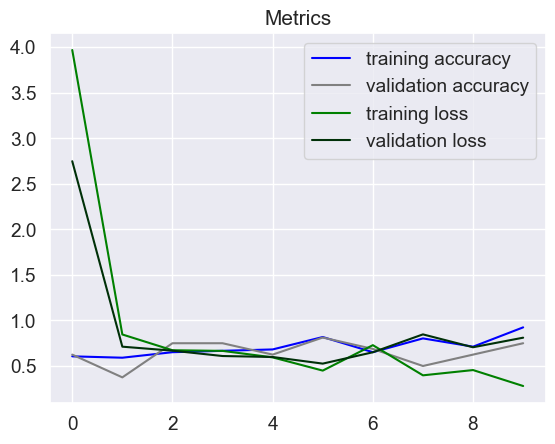

In [141]:
# plot the training and validation accuracies and the training and validation losses
loss2 = history2.history['loss']
accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']
epochs2 = range(len(loss2))

plt.plot(epochs2, accuracy2, label='training accuracy')
plt.plot(epochs2, val_accuracy2, label='validation accuracy')
plt.plot(epochs2, loss2, label='training loss')
plt.plot(epochs2, val_loss2, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [143]:
binary_test_loss, binary_test_accuracy = cnn_model2.evaluate(test_data2)
print('Testing accuracy:', binary_test_accuracy)

1/1 [==============================] - 0s 171ms/step - loss: 0.8727 - accuracy: 0.5714
Testing accuracy: 0.5714285969734192


# FFN with Kaggle Dataset

In [158]:
ffn_model = Sequential([
    Flatten(input_shape=(150, 150, 4)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

ffn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

ffn_history = ffn_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
15/15 [==============================] - 10s 566ms/step - loss: 11.3465 - accuracy: 0.1041 - val_loss: 6.1160 - val_accuracy: 0.1043
Epoch 2/10
15/15 [==============================] - 10s 683ms/step - loss: 3.7235 - accuracy: 0.1714 - val_loss: 3.4238 - val_accuracy: 0.1565
Epoch 3/10
15/15 [==============================] - 11s 714ms/step - loss: 2.1017 - accuracy: 0.3731 - val_loss: 3.2618 - val_accuracy: 0.1130
Epoch 4/10
15/15 [==============================] - 8s 526ms/step - loss: 1.4115 - accuracy: 0.5683 - val_loss: 3.3716 - val_accuracy: 0.1565
Epoch 5/10
15/15 [==============================] - 7s 451ms/step - loss: 1.0389 - accuracy: 0.6876 - val_loss: 3.2647 - val_accuracy: 0.1565
Epoch 6/10
15/15 [==============================] - 7s 440ms/step - loss: 0.7477 - accuracy: 0.8200 - val_loss: 3.5072 - val_accuracy: 0.0957
Epoch 7/10
15/15 [==============================] - 7s 456ms/step - loss: 0.6246 - accuracy: 0.8330 - val_loss: 3.6591 - val_accuracy: 0.1478
Ep

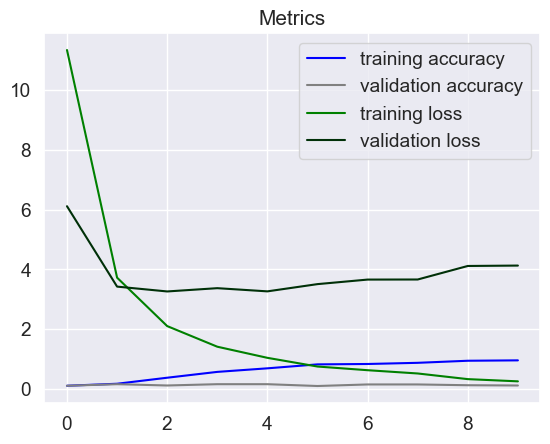

In [159]:
ffn_loss = ffn_history.history['loss']
ffn_accuracy = ffn_history.history['accuracy']
ffn_val_loss = ffn_history.history['val_loss']
ffn_val_accuracy = ffn_history.history['val_accuracy']
ffn_epochs = range(len(loss))

plt.plot(ffn_epochs, ffn_accuracy, label='training accuracy')
plt.plot(ffn_epochs, ffn_val_accuracy, label='validation accuracy')
plt.plot(ffn_epochs, ffn_loss, label='training loss')
plt.plot(ffn_epochs, ffn_val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [160]:
ffn_test_loss, ffn_test_accuracy = ffn_model.evaluate(test_data)
print('Testing accuracy:', ffn_test_accuracy)

5/5 [==============================] - 0s 45ms/step - loss: 4.3394 - accuracy: 0.1655
Testing accuracy: 0.16551724076271057


In [161]:
ffn_model2 = Sequential([
    Flatten(input_shape=(150, 150, 4)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(18, activation='softmax')
])

ffn_model2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

ffn_history2 = ffn_model2.fit(train_data2, validation_data=val_data2, epochs=10)

Epoch 1/10
3/3 [==============================] - 2s 601ms/step - loss: 11.2210 - accuracy: 0.5303 - val_loss: 2.5501 - val_accuracy: 0.3125
Epoch 2/10
3/3 [==============================] - 1s 479ms/step - loss: 2.7792 - accuracy: 0.5909 - val_loss: 2.7907 - val_accuracy: 0.5625
Epoch 3/10
3/3 [==============================] - 1s 478ms/step - loss: 1.3310 - accuracy: 0.7879 - val_loss: 2.7318 - val_accuracy: 0.5625
Epoch 4/10
3/3 [==============================] - 1s 480ms/step - loss: 0.7873 - accuracy: 0.8182 - val_loss: 2.5907 - val_accuracy: 0.6875
Epoch 5/10
3/3 [==============================] - 1s 471ms/step - loss: 0.2733 - accuracy: 0.8939 - val_loss: 2.4991 - val_accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 1s 472ms/step - loss: 3.5905 - accuracy: 0.5455 - val_loss: 3.0530 - val_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 1s 465ms/step - loss: 0.5310 - accuracy: 0.8333 - val_loss: 9.5161 - val_accuracy: 0.6250
Epoch 8/10
3/3 [===

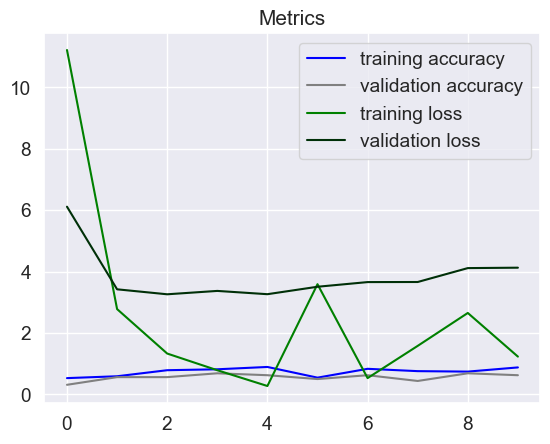

In [162]:
ffn_loss2 = ffn_history2.history['loss']
ffn_accuracy2 = ffn_history2.history['accuracy']
ffn_val_loss2 = ffn_history2.history['val_loss']
ffn_val_accuracy2 = ffn_history2.history['val_accuracy']
ffn_epochs2 = range(len(loss))

plt.plot(ffn_epochs2, ffn_accuracy2, label='training accuracy')
plt.plot(ffn_epochs2, ffn_val_accuracy2, label='validation accuracy')
plt.plot(ffn_epochs2, ffn_loss2, label='training loss')
plt.plot(ffn_epochs2, ffn_val_loss, label='validation loss')
plt.legend()
plt.title('Metrics')
plt.show()

In [163]:
ffn_binary_test_loss, ffn_binary_test_accuracy = ffn_model2.evaluate(test_data2)
print('Testing accuracy:', ffn_binary_test_accuracy)

1/1 [==============================] - 0s 156ms/step - loss: 8.4784 - accuracy: 0.6071
Testing accuracy: 0.6071428656578064


# KNN with PokeAPI Dataset

In [144]:
# split the data into training and testing sets
X_ratio = pokemon_df_stat_ratios.drop('Type 1', axis=1)
y_ratio = pokemon_df_stat_ratios['Type 1']

X_train_ratio, X_test_ratio, y_train_ratio, y_test_ratio = train_test_split(X_ratio, y_ratio, test_size=.2, random_state=42)

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# create and fit KNN model
knn_ratio_df = KNeighborsClassifier()
knn_ratio_df.fit(X_train_ratio, y_train_ratio)

KNeighborsClassifier()

In [146]:
# get accuracy, precision, and recall scores
yhat_train_knn = knn_ratio_df.predict(X_train_ratio)
yhat_test_knn = knn_ratio_df.predict(X_test_ratio)
print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_knn))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_knn))

print('Training precision:', precision_score(y_train_ratio, yhat_train_knn, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_knn, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_knn, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_knn, average='macro'))

Training accuracy: 0.46905940594059403
Testing accuracy: 0.22772277227722773
Training precision: 0.5043572889488037
Testing precision: 0.26518549428111804
Training recall: 0.4366251267534418
Testing recall: 0.20553506353944953


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Decision Trees with PokeAPI Dataset

In [147]:
from sklearn.tree import DecisionTreeClassifier

# create and fit a decision tree model
dt_ratio_df = DecisionTreeClassifier()
dt_ratio_df.fit(X_train_ratio, y_train_ratio)

DecisionTreeClassifier()

In [148]:
# get accuracy, precision, and recall scores
yhat_train_dt = dt_ratio_df.predict(X_train_ratio)
yhat_test_dt = dt_ratio_df.predict(X_test_ratio)
print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_dt))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_dt))

print('Training precision:', precision_score(y_train_ratio, yhat_train_dt, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_dt, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_dt, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_dt, average='macro'))

Training accuracy: 0.9789603960396039
Testing accuracy: 0.1782178217821782
Training precision: 0.9862301733646763
Testing precision: 0.19060614403751655
Training recall: 0.975336831513732
Testing recall: 0.1622112577156437


# Random Forests with PokeAPI Dataset

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# create a pipeline
rf_pipeline = Pipeline([
    ('random_forest', RandomForestClassifier())
])

# assign different values to tuning parameters
rf_params = {'random_forest__max_depth': [i for i in range(5, 16)],
         'random_forest__n_estimators': [i for i in range(60, 161, 20)],
         'random_forest__criterion': ['gini', 'entropy', 'log_loss'],
         'random_forest__max_features': ['sqrt', 'log2']}

# do a grid search and fit the model
grid_search = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=10)
grid_search.fit(X_train_ratio, y_train_ratio)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('random_forest',
                                        RandomForestClassifier())]),
             param_grid={'random_forest__criterion': ['gini', 'entropy',
                                                      'log_loss'],
                         'random_forest__max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15],
                         'random_forest__max_features': ['sqrt', 'log2'],
                         'random_forest__n_estimators': [60, 80, 100, 120, 140,
                                                         160]})

In [65]:
# get the best parameters
grid_search.best_params_

{'random_forest__criterion': 'entropy',
 'random_forest__max_depth': 7,
 'random_forest__max_features': 'log2',
 'random_forest__n_estimators': 60}

In [149]:
# create a model with the best parameter values
best_params_rf = RandomForestClassifier(max_depth=7, criterion='entropy', max_features='log2', n_estimators=60)
best_params_rf.fit(X_train_ratio, y_train_ratio)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='log2',
                       n_estimators=60)

In [150]:
# get accuracy, precision, and recall scores
yhat_train_rf = rf_best_params_pipeline.predict(X_train_ratio)
yhat_test_rf = rf_best_params_pipeline.predict(X_test_ratio)

print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_rf))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_rf))

print('Training precision:', precision_score(y_train_ratio, yhat_train_rf, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_rf, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_rf, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_rf, average='macro'))

Training accuracy: 0.8514851485148515
Testing accuracy: 0.26732673267326734
Training precision: 0.9233500722708224
Testing precision: 0.33064950507526386
Training recall: 0.8183750136865423
Testing recall: 0.22197613951999917


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Ensemble Model with KNN, Decision Trees, and Random Forests with PokeAPI Dataset

In [85]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble
ensemble = VotingClassifier(estimators=[
    ('knn', knn_ratio_df),
    ('dt', dt_ratio_df),
    ('random_forest', best_params_rf)
], voting='hard')

# assign different values to tuning parameters
param_grid = {'knn__n_neighbors': [3, 5, 7, 10],
             'dt__max_depth': [3, 5, 7, 10],
             'random_forest__n_estimators': [50, 60, 70, 80, 90, 100],
             'random_forest__max_depth': [3, 5, 7, 10]}

# do a grid search and fit the model
ensemble_grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=5)
ensemble_grid_search.fit(X_train_ratio, y_train_ratio)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('knn',
                                                     KNeighborsClassifier()),
                                                    ('dt',
                                                     DecisionTreeClassifier()),
                                                    ('random_forest',
                                                     RandomForestClassifier(criterion='entropy',
                                                                            max_depth=7,
                                                                            max_features='log2',
                                                                            n_estimators=60))]),
             param_grid={'dt__max_depth': [3, 5, 7, 10],
                         'knn__n_neighbors': [3, 5, 7, 10],
                         'random_forest__max_depth': [3, 5, 7, 10],
                         'random_forest__n_estimators': [50, 60, 70, 80, 90,
                                                         100]})

In [86]:
# get the best parameters
ensemble_grid_search.best_params_

{'dt__max_depth': 3,
 'knn__n_neighbors': 5,
 'random_forest__max_depth': 7,
 'random_forest__n_estimators': 90}

In [87]:
# create a model with the best parameter values
ensemble_best_params = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('random_forest', RandomForestClassifier(max_depth=7, n_estimators=90))
])

ensemble_best_params.fit(X_train_ratio, y_train_ratio)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier(max_depth=3)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=90))])

In [89]:
# Predict using the ensemble
yhat_train_ensemble = ensemble_best_params.predict(X_train_ratio)
yhat_test_ensemble = ensemble_best_params.predict(X_test_ratio)

print('Training accuracy:', accuracy_score(y_train_ratio, yhat_train_ensemble))
print('Testing accuracy:', accuracy_score(y_test_ratio, yhat_test_ensemble))

print('Training precision:', precision_score(y_train_ratio, yhat_train_ensemble, average='macro'))
print('Testing precision:', precision_score(y_test_ratio, yhat_test_ensemble, average='macro'))

print('Training recall:', recall_score(y_train_ratio, yhat_train_ensemble, average='macro'))
print('Testing recall:', recall_score(y_test_ratio, yhat_test_ensemble, average='macro'))

Training accuracy: 0.5334158415841584
Testing accuracy: 0.25742574257425743
Training precision: 0.6597305633476811
Testing precision: 0.27899430816097476
Training recall: 0.44740201819197245
Testing recall: 0.1957861623431799


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# K-Means Clustering

In [166]:
from sklearn.cluster import KMeans

kmeans_ratio_df = KMeans(n_init=10)
kmeans_ratio_df.fit(X_train_ratio)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_init=10)

In [169]:
from sklearn.metrics import silhouette_score

yhat_train_kmeans = kmeans_ratio_df.predict(X_train_ratio)
yhat_test_kmeans = kmeans_ratio_df.predict(X_test_ratio)
print('Training silhouette score:', silhouette_score(X_train_ratio, yhat_train_kmeans))
print('Testing silhouette score:', silhouette_score(X_test_ratio, yhat_test_kmeans))

Training silhouette score: 0.32204929763586376
Testing silhouette score: 0.2973049904669683
